# 🚴‍♂️ 외국인 따릉이 월별 이용 패턴 분석
## 월별 데이터를 활용한 효율적인 증감 분석 (2024년 7-12월)

### 📊 분석 목표
- 외국인 따릉이 이용량의 월별 변화 패턴 파악
- 월별 증감률 및 트렌드 분석  
- 계절별 이용 패턴 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
plt.style.use('default')
sns.set_palette("husl")

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 로드 완료!")


✅ 라이브러리 로드 완료!


In [2]:
# 월별 데이터 로드 (cp949 인코딩 사용)
file_path = '서울특별시 공공자전거 외국인 대여정보(월별)_24.7-12.csv'

try:
    df_monthly = pd.read_csv(file_path, encoding='cp949')
    print(f"✅ 월별 데이터를 성공적으로 불러왔습니다!")
    print(f"📊 데이터 크기: {df_monthly.shape}")
    print(f"📋 원본 컬럼명: {df_monthly.columns.tolist()}")
    
    # 컬럼명 정리
    df_monthly.columns = ['년월', '대여소명', '대여건수', '반납건수']
    print(f"✅ 정리된 컬럼명: {df_monthly.columns.tolist()}")
    
    print(f"\n📅 데이터 미리보기:")
    print(df_monthly.head(10))
    
except Exception as e:
    print(f"❌ 데이터 로드 실패: {e}")
    print("인코딩을 다시 시도해보겠습니다...")
    
    # 다른 인코딩 시도
    encodings = ['utf-8', 'utf-8-sig', 'euc-kr']
    for encoding in encodings:
        try:
            df_monthly = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ {encoding} 인코딩으로 성공!")
            df_monthly.columns = ['년월', '대여소명', '대여건수', '반납건수']
            break
        except:
            continue


✅ 월별 데이터를 성공적으로 불러왔습니다!
📊 데이터 크기: (6950, 4)
📋 원본 컬럼명: ['???', '?뿩???', '?뿩???.1', '??????']
✅ 정리된 컬럼명: ['년월', '대여소명', '대여건수', '반납건수']

📅 데이터 미리보기:
       년월                                    대여소명  대여건수  반납건수
0  202407      1001. ?????? ???? ????(?????? ???)     0     1
1  202407           1004. ?Ｚ?????????? ??????????     1     0
2  202407               1009. ????4????(????????)     3     2
3  202407                     1011. LIGA ????? ??     1     0
4  202407                1012. ??????????????? ??     1     0
5  202407  1019. ?????????????(????? ?밢?? ??????)     2     1
6  202407                    102. ?????? 1???? ??     7     7
7  202407                        1020. ??????????     2     2
8  202407                       1024.  ??????? ??     1     2
9  202407                         1029. ?????????     0     2


In [3]:
# 데이터 전처리 및 기본 정보 확인
print("=== 📊 데이터 전처리 ===")

# 데이터 타입 확인 및 변환
print(f"데이터 타입 변환 전:")
print(df_monthly.dtypes)

# 년월을 datetime 형식으로 변환
df_monthly['년월'] = pd.to_datetime(df_monthly['년월'], format='%Y%m')
df_monthly['대여건수'] = pd.to_numeric(df_monthly['대여건수'], errors='coerce').fillna(0)
df_monthly['반납건수'] = pd.to_numeric(df_monthly['반납건수'], errors='coerce').fillna(0)

# 월 정보 추가
df_monthly['월'] = df_monthly['년월'].dt.month
df_monthly['년월_str'] = df_monthly['년월'].dt.strftime('%Y년 %m월')

print(f"\n✅ 데이터 타입 변환 완료:")
print(df_monthly.dtypes)

print(f"\n📋 기본 정보:")
print(f"📅 분석 기간: {df_monthly['년월'].min().strftime('%Y년 %m월')} ~ {df_monthly['년월'].max().strftime('%Y년 %m월')}")
print(f"📍 총 대여소 수: {df_monthly['대여소명'].nunique():,}개")
print(f"📊 총 데이터 행 수: {len(df_monthly):,}건")
print(f"📈 총 대여건수: {df_monthly['대여건수'].sum():,}건")
print(f"📉 총 반납건수: {df_monthly['반납건수'].sum():,}건")

# 결측값 확인
print(f"\n🔍 결측값 확인:")
print(df_monthly.isnull().sum())


=== 📊 데이터 전처리 ===
데이터 타입 변환 전:
년월       int64
대여소명    object
대여건수     int64
반납건수     int64
dtype: object

✅ 데이터 타입 변환 완료:
년월        datetime64[ns]
대여소명              object
대여건수               int64
반납건수               int64
월                  int32
년월_str            object
dtype: object

📋 기본 정보:
📅 분석 기간: 2024년 07월 ~ 2024년 12월
📍 총 대여소 수: 2,102개
📊 총 데이터 행 수: 6,950건
📈 총 대여건수: 31,776건
📉 총 반납건수: 31,265건

🔍 결측값 확인:
년월        0
대여소명      0
대여건수      0
반납건수      0
월         0
년월_str    0
dtype: int64


In [4]:
# 월별 집계 (이미 월별 데이터이므로 대여소별로 합계)
monthly_summary = df_monthly.groupby('년월').agg({
    '대여건수': 'sum',
    '반납건수': 'sum',
    '대여소명': 'nunique'  # 해당 월에 이용된 대여소 수
}).reset_index()

monthly_summary['총_이용건수'] = monthly_summary['대여건수'] + monthly_summary['반납건수']
monthly_summary['년월_str'] = monthly_summary['년월'].dt.strftime('%Y년 %m월')
monthly_summary['월'] = monthly_summary['년월'].dt.month

# 월별 증감률 계산 (전월 대비)
monthly_summary['대여_증감률'] = monthly_summary['대여건수'].pct_change() * 100
monthly_summary['반납_증감률'] = monthly_summary['반납건수'].pct_change() * 100
monthly_summary['총이용_증감률'] = monthly_summary['총_이용건수'].pct_change() * 100

print("=== 📊 월별 이용 현황 요약 ===")
display_cols = ['년월_str', '대여건수', '반납건수', '총_이용건수', '대여소명']
summary_display = monthly_summary[display_cols].copy()
summary_display.columns = ['월', '대여건수', '반납건수', '총이용건수', '이용대여소수']
print(summary_display.to_string(index=False))

print(f"\n=== 📈 월별 증감률 (전월 대비) ===")
for idx, row in monthly_summary.iterrows():
    if idx == 0:
        print(f"📅 {row['년월_str']}: 🔥 기준월")
        print(f"   📊 대여: {row['대여건수']:,}건 | 반납: {row['반납건수']:,}건 | 총: {row['총_이용건수']:,}건")
    else:
        # 이모지 선택
        rental_emoji = "📈" if row['대여_증감률'] > 0 else "📉" if row['대여_증감률'] < 0 else "➡️"
        return_emoji = "📈" if row['반납_증감률'] > 0 else "📉" if row['반납_증감률'] < 0 else "➡️"
        total_emoji = "📈" if row['총이용_증감률'] > 0 else "📉" if row['총이용_증감률'] < 0 else "➡️"
        
        print(f"\n📅 {row['년월_str']}:")
        print(f"   {rental_emoji} 대여: {row['대여_증감률']:+.1f}% ({row['대여건수']:,}건)")
        print(f"   {return_emoji} 반납: {row['반납_증감률']:+.1f}% ({row['반납건수']:,}건)")
        print(f"   {total_emoji} 총이용: {row['총이용_증감률']:+.1f}% ({row['총_이용건수']:,}건)")


=== 📊 월별 이용 현황 요약 ===
        월  대여건수  반납건수  총이용건수  이용대여소수
2024년 07월  6602  6493  13095    1276
2024년 08월  5091  5024  10115    1171
2024년 09월  7271  7143  14414    1346
2024년 10월  7108  6989  14097    1369
2024년 11월  4296  4231   8527    1091
2024년 12월  1408  1385   2793     697

=== 📈 월별 증감률 (전월 대비) ===
📅 2024년 07월: 🔥 기준월
   📊 대여: 6,602건 | 반납: 6,493건 | 총: 13,095건

📅 2024년 08월:
   📉 대여: -22.9% (5,091건)
   📉 반납: -22.6% (5,024건)
   📉 총이용: -22.8% (10,115건)

📅 2024년 09월:
   📈 대여: +42.8% (7,271건)
   📈 반납: +42.2% (7,143건)
   📈 총이용: +42.5% (14,414건)

📅 2024년 10월:
   📉 대여: -2.2% (7,108건)
   📉 반납: -2.2% (6,989건)
   📉 총이용: -2.2% (14,097건)

📅 2024년 11월:
   📉 대여: -39.6% (4,296건)
   📉 반납: -39.5% (4,231건)
   📉 총이용: -39.5% (8,527건)

📅 2024년 12월:
   📉 대여: -67.2% (1,408건)
   📉 반납: -67.3% (1,385건)
   📉 총이용: -67.2% (2,793건)


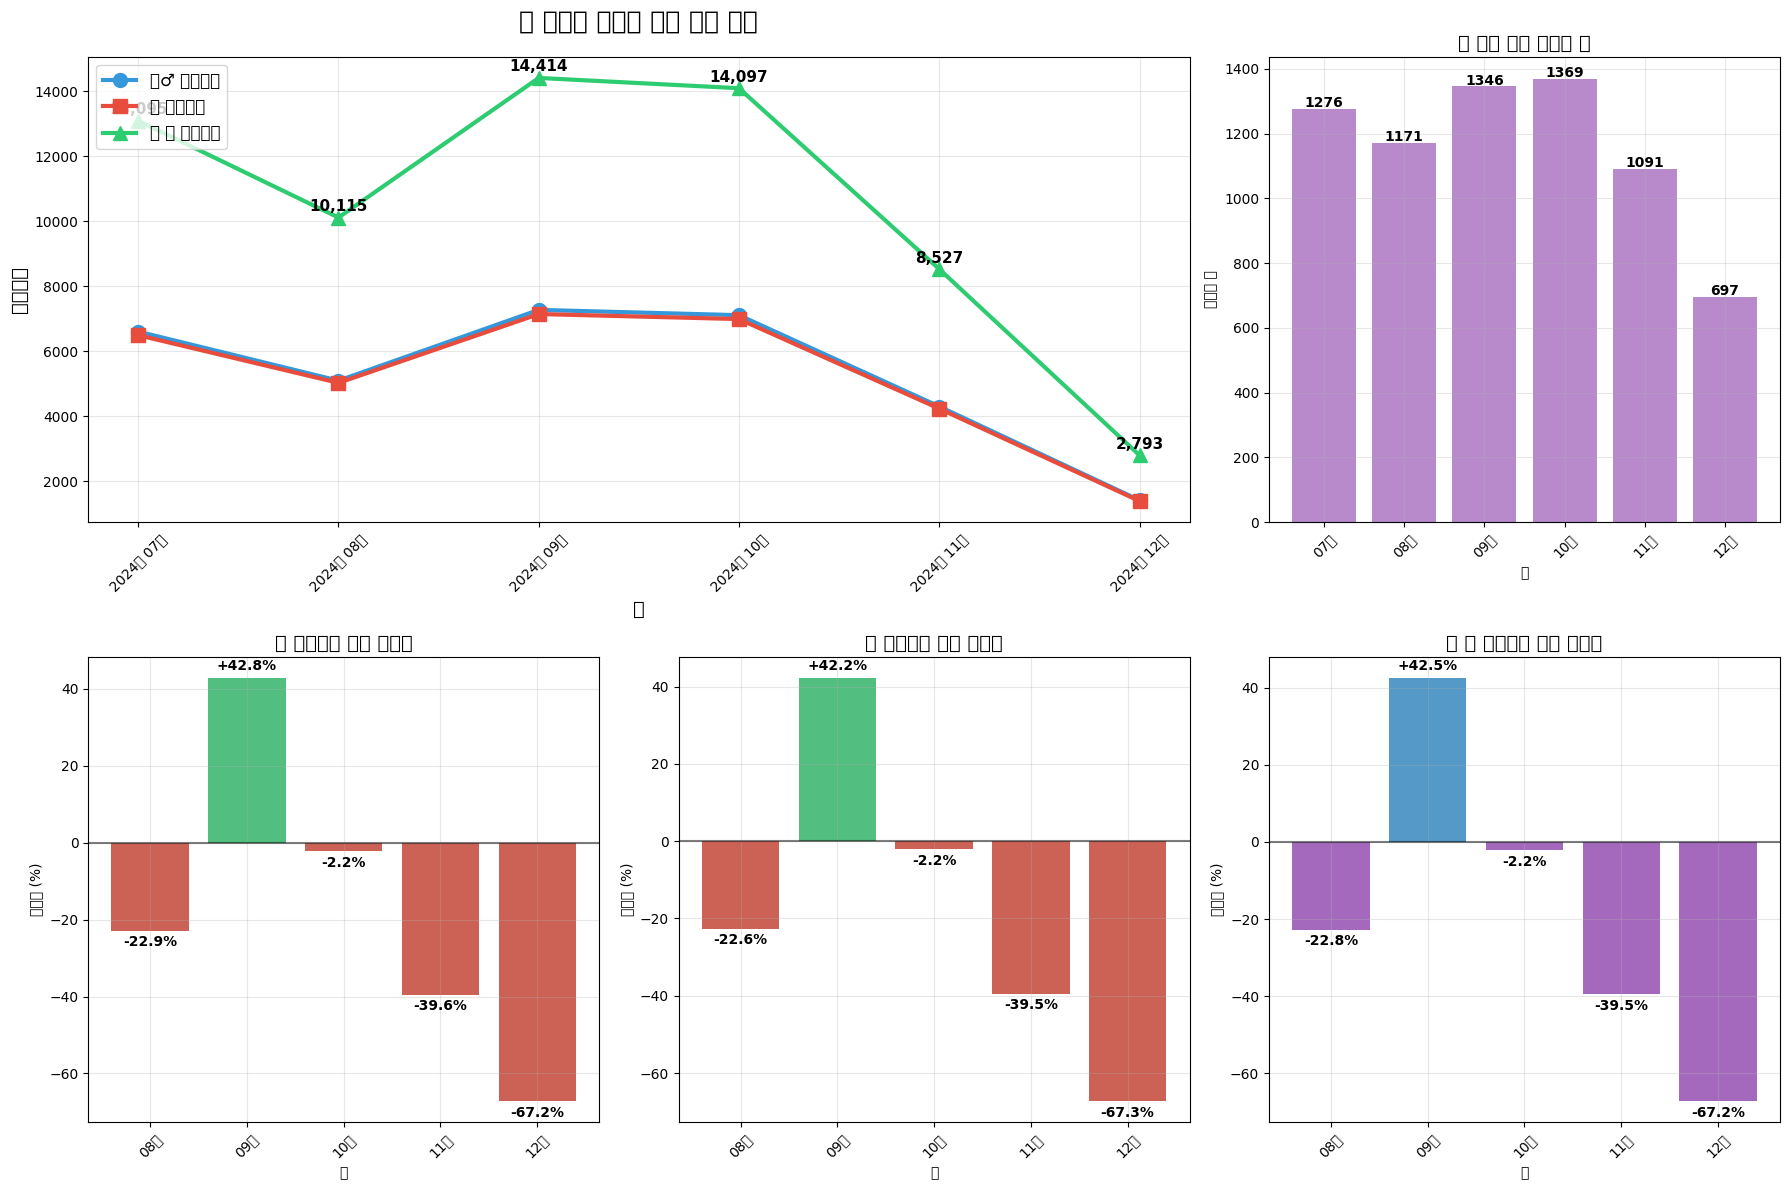

In [5]:
# 월별 트렌드 종합 시각화
fig = plt.figure(figsize=(18, 12))

# 1. 월별 이용건수 추이 (메인 차트)
plt.subplot(2, 3, (1, 2))  # 2행 3열 중 첫 번째 행의 1,2번 위치
months = monthly_summary['년월_str']
x_pos = range(len(months))

plt.plot(x_pos, monthly_summary['대여건수'], 'o-', linewidth=3, markersize=10, 
         label='🚴‍♂️ 대여건수', color='#3498db')
plt.plot(x_pos, monthly_summary['반납건수'], 's-', linewidth=3, markersize=10, 
         label='🏁 반납건수', color='#e74c3c')
plt.plot(x_pos, monthly_summary['총_이용건수'], '^-', linewidth=3, markersize=10, 
         label='📊 총 이용건수', color='#2ecc71')

plt.title('📈 외국인 따릉이 월별 이용 추이', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('이용건수', fontsize=14)
plt.xlabel('월', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(x_pos, months, rotation=45)

# 값 표시
for i, (rental, return_val, total) in enumerate(zip(monthly_summary['대여건수'], 
                                                   monthly_summary['반납건수'], 
                                                   monthly_summary['총_이용건수'])):
    plt.text(i, total + 200, f'{total:,}', ha='center', fontsize=11, fontweight='bold')

# 2. 월별 대여소 이용 수
plt.subplot(2, 3, 3)
bars = plt.bar(x_pos, monthly_summary['대여소명'], color='#9b59b6', alpha=0.7)
plt.title('📍 월별 이용 대여소 수', fontsize=14, fontweight='bold')
plt.ylabel('대여소 수')
plt.xlabel('월')
plt.xticks(x_pos, [m.split()[1] for m in months], rotation=45)
plt.grid(True, alpha=0.3)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{int(bar.get_height())}', ha='center', fontweight='bold')

# 3. 월별 증감률 (대여)
plt.subplot(2, 3, 4)
if len(monthly_summary) > 1:
    changes = monthly_summary[1:]['대여_증감률']
    change_months = monthly_summary[1:]['년월_str']
    colors = ['#27ae60' if x > 0 else '#c0392b' if x < 0 else '#7f8c8d' for x in changes]
    
    bars = plt.bar(range(len(changes)), changes, color=colors, alpha=0.8)
    plt.title('📈 대여건수 월별 증감률', fontsize=14, fontweight='bold')
    plt.ylabel('증감률 (%)')
    plt.xlabel('월')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.xticks(range(len(changes)), [m.split()[1] for m in change_months], rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, changes)):
        plt.text(bar.get_x() + bar.get_width()/2, 
                val + (2 if val > 0 else -4), 
                f'{val:+.1f}%', ha='center', fontweight='bold')

# 4. 월별 증감률 (반납)
plt.subplot(2, 3, 5)
if len(monthly_summary) > 1:
    changes = monthly_summary[1:]['반납_증감률']
    colors = ['#27ae60' if x > 0 else '#c0392b' if x < 0 else '#7f8c8d' for x in changes]
    
    bars = plt.bar(range(len(changes)), changes, color=colors, alpha=0.8)
    plt.title('📉 반납건수 월별 증감률', fontsize=14, fontweight='bold')
    plt.ylabel('증감률 (%)')
    plt.xlabel('월')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.xticks(range(len(changes)), [m.split()[1] for m in change_months], rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, changes)):
        plt.text(bar.get_x() + bar.get_width()/2, 
                val + (2 if val > 0 else -4), 
                f'{val:+.1f}%', ha='center', fontweight='bold')

# 5. 총 이용건수 증감률
plt.subplot(2, 3, 6)
if len(monthly_summary) > 1:
    changes = monthly_summary[1:]['총이용_증감률']
    colors = ['#2980b9' if x > 0 else '#8e44ad' if x < 0 else '#7f8c8d' for x in changes]
    
    bars = plt.bar(range(len(changes)), changes, color=colors, alpha=0.8)
    plt.title('📊 총 이용건수 월별 증감률', fontsize=14, fontweight='bold')
    plt.ylabel('증감률 (%)')
    plt.xlabel('월')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.xticks(range(len(changes)), [m.split()[1] for m in change_months], rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, changes)):
        plt.text(bar.get_x() + bar.get_width()/2, 
                val + (2 if val > 0 else -4), 
                f'{val:+.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [6]:
# 월별 인기 대여소 TOP 5 변화 분석
print("=== 🏆 월별 인기 대여소 TOP 5 변화 ===")
print("\n" + "="*100)

for month in sorted(df_monthly['년월'].unique()):
    month_str = month.strftime('%Y년 %m월')
    month_data = df_monthly[df_monthly['년월'] == month]
    
    # 대여 TOP 5
    rental_top5 = month_data.nlargest(5, '대여건수')
    # 반납 TOP 5  
    return_top5 = month_data.nlargest(5, '반납건수')
    
    print(f"\n📅 {month_str} 월별 분석:")
    print(f"📊 총 이용 대여소: {len(month_data)}개 | 총 대여: {month_data['대여건수'].sum():,}건 | 총 반납: {month_data['반납건수'].sum():,}건")
    
    print(f"\n🚴‍♂️ 대여 TOP 5:")
    for i, (_, row) in enumerate(rental_top5.iterrows(), 1):
        station_name = row['대여소명'][:40] + '...' if len(row['대여소명']) > 40 else row['대여소명']
        print(f"  {i}. {station_name}: {row['대여건수']:,}건")
    
    print(f"\n🏁 반납 TOP 5:")
    for i, (_, row) in enumerate(return_top5.iterrows(), 1):
        station_name = row['대여소명'][:40] + '...' if len(row['대여소명']) > 40 else row['대여소명']
        print(f"  {i}. {station_name}: {row['반납건수']:,}건")
    
    print("-" * 100)


=== 🏆 월별 인기 대여소 TOP 5 변화 ===


📅 2024년 07월 월별 분석:
📊 총 이용 대여소: 1276개 | 총 대여: 6,602건 | 총 반납: 6,493건

🚴‍♂️ 대여 TOP 5:
  1. 207. ??????? 1???? ??: 190건
  2. 4217. ??????? ?????????: 97건
  3. 474.???빮??????????? 1???? ????: 86건
  4. 3515. ???? ?????繫??: 78건
  5. 502. ???(??????????)?? 1???? ??: 71건

🏁 반납 TOP 5:
  1. 207. ??????? 1???? ??: 145건
  2. 4217. ??????? ?????????: 96건
  3. 502. ???(??????????)?? 1???? ??: 85건
  4. 2525.??????????? 2?? ??: 71건
  5. 4791. ??????9?? ??: 69건
----------------------------------------------------------------------------------------------------

📅 2024년 08월 월별 분석:
📊 총 이용 대여소: 1171개 | 총 대여: 5,091건 | 총 반납: 5,024건

🚴‍♂️ 대여 TOP 5:
  1. 207. ??????? 1???? ??: 130건
  2. 4217. ??????? ?????????: 107건
  3. 3515. ???? ?????繫??: 62건
  4. 474.???빮??????????? 1???? ????: 58건
  5. 2217.????θ????? ???? ??: 55건

🏁 반납 TOP 5:
  1. 207. ??????? 1???? ??: 132건
  2. 4217. ??????? ?????????: 84건
  3. 2217.????θ????? ???? ??: 81건
  4. 825. ???????? ??μ??? ??: 79건
  5. 502. ???(?

In [7]:
# 종합 분석 및 인사이트
print("="*100)
print("🎯 외국인 따릉이 월별 이용 패턴 종합 분석 결과")
print("="*100)

# 기본 통계
print(f"📅 분석 기간: {monthly_summary['년월_str'].iloc[0]} ~ {monthly_summary['년월_str'].iloc[-1]}")
print(f"📊 총 분석 개월: {len(monthly_summary)}개월")
print(f"📈 전체 대여건수: {monthly_summary['대여건수'].sum():,}건")
print(f"📉 전체 반납건수: {monthly_summary['반납건수'].sum():,}건")
print(f"📊 전체 이용건수: {monthly_summary['총_이용건수'].sum():,}건")

# 최고/최저 분석
max_idx = monthly_summary['총_이용건수'].idxmax()
min_idx = monthly_summary['총_이용건수'].idxmin()

print(f"\n🔥 가장 활발했던 월: {monthly_summary.iloc[max_idx]['년월_str']}")
print(f"   총 이용: {monthly_summary.iloc[max_idx]['총_이용건수']:,}건")
print(f"   (대여: {monthly_summary.iloc[max_idx]['대여건수']:,} | 반납: {monthly_summary.iloc[max_idx]['반납건수']:,})")

print(f"\n❄️ 가장 저조했던 월: {monthly_summary.iloc[min_idx]['년월_str']}")
print(f"   총 이용: {monthly_summary.iloc[min_idx]['총_이용건수']:,}건")
print(f"   (대여: {monthly_summary.iloc[min_idx]['대여건수']:,} | 반납: {monthly_summary.iloc[min_idx]['반납건수']:,})")

# 증감률 분석
if len(monthly_summary) > 1:
    valid_data = monthly_summary.dropna(subset=['총이용_증감률'])
    if len(valid_data) > 0:
        max_increase_idx = valid_data['총이용_증감률'].idxmax()
        max_decrease_idx = valid_data['총이용_증감률'].idxmin()
        
        print(f"\n📈 최대 증가월: {monthly_summary.iloc[max_increase_idx]['년월_str']}")
        print(f"   증가율: {monthly_summary.iloc[max_increase_idx]['총이용_증감률']:+.1f}%")
        
        print(f"\n📉 최대 감소월: {monthly_summary.iloc[max_decrease_idx]['년월_str']}")
        print(f"   감소율: {monthly_summary.iloc[max_decrease_idx]['총이용_증감률']:+.1f}%")

# 평균 통계
print(f"\n📊 월별 평균 통계:")
print(f"   평균 월별 이용건수: {monthly_summary['총_이용건수'].mean():,.0f}건")
print(f"   평균 월별 대여건수: {monthly_summary['대여건수'].mean():,.0f}건")
print(f"   평균 월별 반납건수: {monthly_summary['반납건수'].mean():,.0f}건")
print(f"   평균 이용 대여소 수: {monthly_summary['대여소명'].mean():,.0f}개")

# 계절별 분석
summer_data = monthly_summary[monthly_summary['월'].isin([7, 8, 9])]
autumn_data = monthly_summary[monthly_summary['월'].isin([10, 11])]
winter_data = monthly_summary[monthly_summary['월'].isin([12])]

print(f"\n🌡️ 계절별 분석:")
if len(summer_data) > 0:
    summer_avg = summer_data['총_이용건수'].mean()
    print(f"🌞 여름(7-9월) 평균: {summer_avg:,.0f}건/월")

if len(autumn_data) > 0:
    autumn_avg = autumn_data['총_이용건수'].mean()
    print(f"🍂 가을(10-11월) 평균: {autumn_avg:,.0f}건/월")

if len(winter_data) > 0:
    winter_avg = winter_data['총_이용건수'].mean()
    print(f"❄️ 겨울(12월) 평균: {winter_avg:,.0f}건/월")

# 계절간 비교
if len(summer_data) > 0 and len(autumn_data) > 0:
    seasonal_change = ((autumn_avg - summer_avg) / summer_avg) * 100
    print(f"🌡️ 여름→가을 변화: {seasonal_change:+.1f}%")

if len(autumn_data) > 0 and len(winter_data) > 0:
    winter_change = ((winter_avg - autumn_avg) / autumn_avg) * 100
    print(f"🌡️ 가을→겨울 변화: {winter_change:+.1f}%")

# 전체 트렌드
total_trend = ((monthly_summary.iloc[-1]['총_이용건수'] - monthly_summary.iloc[0]['총_이용건수']) / monthly_summary.iloc[0]['총_이용건수']) * 100

print(f"\n=== 🎯 주요 인사이트 ===")
if total_trend > 0:
    print(f"📈 전체 트렌드: 증가 추세 ({total_trend:+.1f}%)")
    print(f"💡 외국인 관광객의 따릉이 이용이 지속적으로 증가하고 있습니다.")
else:
    print(f"📉 전체 트렌드: 감소 추세 ({total_trend:+.1f}%)")
    print(f"💡 외국인 관광객의 따릉이 이용이 감소하고 있습니다. 계절적 요인을 고려해야 합니다.")

# 변동성 분석
volatility = monthly_summary['총이용_증감률'].std()
if not pd.isna(volatility):
    print(f"\n📊 월별 변동성: {volatility:.1f}% (표준편차)")
    if volatility > 25:
        print(f"⚠️ 변동성이 매우 높습니다. 월별 이용 패턴이 불안정합니다.")
    elif volatility > 15:
        print(f"📊 변동성이 보통 수준입니다. 계절적 영향이 있습니다.")
    else:
        print(f"✅ 변동성이 낮습니다. 월별 이용 패턴이 안정적입니다.")

print(f"\n" + "="*100)
print(f"📋 분석 완료: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 월별 데이터를 활용한 효율적인 패턴 분석이 완료되었습니다!")
print(f"="*100)


🎯 외국인 따릉이 월별 이용 패턴 종합 분석 결과
📅 분석 기간: 2024년 07월 ~ 2024년 12월
📊 총 분석 개월: 6개월
📈 전체 대여건수: 31,776건
📉 전체 반납건수: 31,265건
📊 전체 이용건수: 63,041건

🔥 가장 활발했던 월: 2024년 09월
   총 이용: 14,414건
   (대여: 7,271 | 반납: 7,143)

❄️ 가장 저조했던 월: 2024년 12월
   총 이용: 2,793건
   (대여: 1,408 | 반납: 1,385)

📈 최대 증가월: 2024년 09월
   증가율: +42.5%

📉 최대 감소월: 2024년 12월
   감소율: -67.2%

📊 월별 평균 통계:
   평균 월별 이용건수: 10,507건
   평균 월별 대여건수: 5,296건
   평균 월별 반납건수: 5,211건
   평균 이용 대여소 수: 1,158개

🌡️ 계절별 분석:
🌞 여름(7-9월) 평균: 12,541건/월
🍂 가을(10-11월) 평균: 11,312건/월
❄️ 겨울(12월) 평균: 2,793건/월
🌡️ 여름→가을 변화: -9.8%
🌡️ 가을→겨울 변화: -75.3%

=== 🎯 주요 인사이트 ===
📉 전체 트렌드: 감소 추세 (-78.7%)
💡 외국인 관광객의 따릉이 이용이 감소하고 있습니다. 계절적 요인을 고려해야 합니다.

📊 월별 변동성: 41.3% (표준편차)
⚠️ 변동성이 매우 높습니다. 월별 이용 패턴이 불안정합니다.

📋 분석 완료: 2025-09-11 16:50:55
🎯 월별 데이터를 활용한 효율적인 패턴 분석이 완료되었습니다!
